In [1]:
import time
import os
import torch
from torchvision import transforms
import random
import numpy as np
import yaml
from PIL import Image
from experiment import VAEXperiment
from models import *
from pathlib import Path

import gymnasium as gym
from gymnasium import ObservationWrapper
from gymnasium.wrappers import PixelObservationWrapper, FrameStack
from gymnasium.spaces import Box, Discrete

from stable_baselines3 import SAC, PPO, A2C

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D


import numpy as np

In [57]:
from gymnasium import ObservationWrapper
from gymnasium.wrappers import PixelObservationWrapper, FrameStack
from gymnasium.spaces import Box, Discrete
import numpy as np
import yaml
from experiment import VAEXperiment
from models import *
import torch
from torchvision import transforms
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class ClipValues(object):
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, tensor):
        return torch.clamp(tensor, self.min_value, self.max_value)
    
class VAE_ENC(ObservationWrapper):
    def __init__(self, env, vae, latent_dim,
                 mean=0,std=0.1,
                 size=(64,64)):
        super().__init__(env)
        #new obs space with std
        #self.observation_space = Box(shape=(2, latent_dim), low=-np.inf, high=np.inf)
        #just mean
        self.observation_space = Box(shape=(latent_dim,), low=-np.inf, high=np.inf)
        
        self.vae = vae
        #transforms
        self.mean = mean
        self.std = std
        self.size = size
        
        
        
    def observation(self, obs):
        #get frame
        #print(obs)
        frame = obs['pixels']#.to('cuda')
        #transform for VAE
        val_transforms = transforms.Compose([transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(),
        AddGaussianNoise(self.mean, self.std),
        transforms.Resize(self.size),
        #transforms.Grayscale(),
        #transforms.Normalize(self.mean, self.std),
        ])
        frame = val_transforms(frame) #(c,h,w)
        frame = torch.unsqueeze(frame, 0)#.to(self.device) #make it (1,c,h,w)
        enc = self.vae.encode(frame)    
        enc = np.array([tensor.detach().cpu().numpy() for tensor in enc])
        #with std
        #enc = np.array([enc[0][0], enc[1][0]]) ## mu, std #  give only mu?
        #just mean
        enc = np.array(enc[0][0])
        return enc
    
def get_vae(version='version_0',log_directory='Code/VAE_RL/logs/BCE_sum_VAE/MSSIMVAE/'):

    model_path=log_directory+'/'+version+'/hparams.yaml'
    ckpt_path=log_directory+'/'+version+'/checkpoints/last.ckpt'

    config = yaml.safe_load(open(model_path))
    model = vae_models[config['model_params']['name']](**config['model_params'])
    ckpt = torch.load(ckpt_path)
    experiment = VAEXperiment(model, config['exp_params'])
    experiment.load_state_dict(ckpt['state_dict'])      
    vae = experiment.model
    return vae

def encode_tensor(vae, processed_images):
#     val_transforms = transforms.Compose([transforms.ToTensor(),
#         #transforms.RandomHorizontalFlip(),
#         AddGaussianNoise(0, 0.1),
#         transforms.Resize((64,64)),
#         #transforms.Grayscale(),
#         #transforms.Normalize(self.mean, self.std),
#         ])
#     processed_images = torch.stack([val_transforms(img) for img in images])
    enc = vae.encode(processed_images)
    enc = np.array([tensor.detach().cpu().numpy() for tensor in enc])
    return enc[0]

def make_trajectories(agent, env, num_of_episodes = 3):
    num_of_episodes=num_of_episodes
    #i=0
    all_frames = []
    all_rewards = []
    all_latent_trajectories = []
    for episode in range(num_of_episodes):
        observation, info = env.reset()
        cum_reward = 0
        done = False
        latent_trajectory = []
        frames = []
        while not done: 
            action, _states = agent.predict(observation, deterministic=True)
            observation, reward, terminated, truncated, info = env.step(action)
            cum_reward += reward
            latent_trajectory.append(np.array(observation[0]))
            #state, reward, terminated, truncated, info = env.step(action)
            #print(terminated, truncated)
            if terminated:
                done = True
            if truncated:
                done = True
        all_rewards.append(cum_reward)
        all_latent_trajectories.append(np.array(latent_trajectory))
    return all_latent_trajectories, all_rewards


def plot_1D_trajectories_with_colors(trajectories, good_trajectory, universe_points, 
                                     left_pos, target_pos, 
                                     start_pos_left, start_pos_middle, start_pos_right,
                                     save_name, plot_title):
    fig, ax = plt.subplots()

    colormaps = [ 'Oranges','Greens','Blues','Purples',  'Reds',
                 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'] 
    
    legend_labels = ['All Observations', 'Start Left', 'Start Middle', 'Start Right', 'Left End', 'Target Position']
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                      for color, label in zip(['lightblue', 'deeppink', 'blueviolet', 'blue', 'red', 'limegreen'], legend_labels)]

    i = 0
    for trajectory in trajectories:
        y = trajectory[:, 0]
        x = np.arange(len(y))
        
        # Plot universe points for each time step
        ax.scatter( np.zeros_like(universe_points)-140, universe_points, c='lightblue', alpha=0.3, label='All Observations')
        ax.scatter( np.zeros_like(left_pos)-110, left_pos, c='red', alpha=0.3, label='Left End')
        ax.scatter( np.zeros_like(start_pos_left)-90, start_pos_left, c='deeppink', alpha=0.1, label='Start Left')
        ax.scatter( np.zeros_like(start_pos_middle)-70, start_pos_middle, c='blueviolet', alpha=0.1, label='Start Middle')
        ax.scatter( np.zeros_like(start_pos_right)-50, start_pos_right, c='blue', alpha=0.1, label='Start Right')
        ax.scatter( np.zeros_like(target_pos)-30, target_pos, c='limegreen', alpha=0.3, label='Target Position')

        num_frames = len(trajectory)
        color_values = np.linspace(0.5, 1, num_frames)

        colormap_index = i % len(colormaps)
        cmap = cm.get_cmap(colormaps[colormap_index])

        normalized_color_values = (color_values - np.min(color_values)) / (np.max(color_values) - np.min(color_values))
        trajectory_colors = cmap(normalized_color_values)

        start_index = int(num_frames * (2 / 3))
        trajectory_colors[:start_index] = trajectory_colors[start_index]

        scatter = ax.scatter(x, y, c=trajectory_colors, alpha=0.3, marker='o', label=f'Trajectory {i+1}')

        legend_handles.append(scatter)

        i += 1
    
    ax.plot(np.arange(len(good_trajectory)), good_trajectory, c= 'limegreen',linestyle='dashed', label = 'Human Trajectory', alpha =0.8)
    legend_handles.append(Line2D([0], [0], color='limegreen', linestyle='dashed', label='Human Trajectory'))

    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Latent Space')
    ax.set_title(plot_titel)

    ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))  # Position the legend to the right of the plot
    plt.savefig(save_name+'.pdf', bbox_inches='tight')
    plt.show()


def plot_2D_trajectories_with_colors(trajectories, good_trajectory, universe_points, 
                                      left_pos, target_pos, 
                                      start_pos_left, start_pos_middle, start_pos_right,
                                      save_name, plot_titel):
    fig, ax = plt.subplots()

    colormaps = [ 'Oranges','Greens', 'Blues','Purples',  'Reds',
                 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'] 
    
    legend_labels = ['All Observations', 'Start Left', 'Start Middle', 'Start Right', 'Left End', 'Target Position']
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label)
                      for color, label in zip(['lightblue', 'deeppink', 'blueviolet', 'blue', 'red', 'limegreen'], legend_labels)]

    i = 0
    for trajectory in trajectories:
        x = trajectory[:, 0]
        y = trajectory[:, 1]
 
        
        ax.scatter(universe_points[:, 0], universe_points[:, 1], c='lightblue', alpha=0.3, label='Universe Points')
        ax.scatter(start_pos_left[:, 0], start_pos_left[:, 1], c='deeppink', alpha=0.1, label='Start Left')
        ax.scatter(start_pos_middle[:, 0], start_pos_middle[:, 1], c='blueviolet', alpha=0.1, label='Start Middle')
        ax.scatter(start_pos_right[:, 0], start_pos_right[:, 1], c='blue', alpha=0.1, label='Start Right')
        ax.scatter(left_pos[:, 0], left_pos[:, 1], c='red', alpha=0.3, label='Left End')
        ax.scatter(target_pos[:, 0], target_pos[:, 1], c='limegreen', alpha=0.3, label='Target Position')

        num_frames = len(trajectory)
        color_values = np.linspace(0.5, 1, num_frames)

        colormap_index = i % len(colormaps)
        cmap = cm.get_cmap(colormaps[colormap_index])

        normalized_color_values = (color_values - np.min(color_values)) / (np.max(color_values) - np.min(color_values))
        trajectory_colors = cmap(normalized_color_values)

        start_index = int(num_frames * (1 / 2))
        trajectory_colors[:start_index] = trajectory_colors[start_index]

        scatter = ax.scatter(x, y, c=trajectory_colors, alpha=0.8, marker='o', label=f'Agent Trajectory')# {i+1}')

        legend_handles.append(scatter)

        i += 1
        
#     def plot_start_lines_2d(start_points, color, linestyle='solid', label=None, alpha=0.4, ax=None):
#         if ax is None:
#             ax = plt.gca()  # Get the current axis if ax is not provided

#         num_start_points = start_points.shape[0]
#         for i in range(num_start_points - 1):
#             ax.plot(start_points[i:i+2, 0], start_points[i:i+2, 1], c=color, alpha=alpha,
#                     linestyle=linestyle, label=label)
            
#     plot_start_lines_2d(good_trajectory, 'limegreen',linestyle='dashed', label = 'Human Trajectory', alpha =0.8)
    ax.plot(good_trajectory[:,0],good_trajectory[:,1], c= 'limegreen',linestyle='dashed', label = 'Human Trajectory', alpha =0.8)
    legend_handles.append(Line2D([0], [0], color='limegreen', linestyle='dashed', label='Human Trajectory'))


    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title(plot_titel)
    
    ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))  # Position the legend to the right of the plot
    
    plt.savefig(save_name + '_2D.pdf', bbox_inches='tight')
    plt.show()
    
def plot_3D_trajectories_with_colors(trajectories,good_trajectory,universe_points, 
                                     left_pos, target_pos, 
                                     start_pos_left, start_pos_middle, start_pos_right,
                                     save_name, plot_title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    colormaps = ['Oranges', 'Greens', 'Purples', 'Blues','Reds',
                 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

    legend_labels = ['All Observations', 'Target Position', 'Left End', 
                      'Agent Trajectory', 'Human Trajectory',
                      'Start Left', 'Start Middle', 'Start Right']

    legend_handles = [
        plt.Line2D([0], [0], color='w', marker='o',  markerfacecolor='lightblue', label='All Observations'),  # All Observations
        plt.Line2D([0], [0], color='w', marker='D',  markerfacecolor='limegreen', label='Target Position'), 
        plt.Line2D([0], [0], color='w', marker='D',  markerfacecolor='red', label='Left End'), 
    ]
    i = 0
    for trajectory in trajectories:
        x = trajectory[:, 0]
        y = trajectory[:, 1]
        z = trajectory[:, 2]

        num_frames = len(trajectory)
        color_values = np.linspace(0.5, 1, num_frames)

        colormap_index = i % len(colormaps)
        cmap = cm.get_cmap(colormaps[colormap_index])

        normalized_color_values = (color_values - np.min(color_values)) / (np.max(color_values) - np.min(color_values))
        trajectory_colors = cmap(normalized_color_values)
        
        start_index = int(num_frames * (1 / 2))
        trajectory_colors[:start_index] = trajectory_colors[start_index]
        
        scatter = ax.scatter(x, y, z, c=trajectory_colors, alpha=0.5, marker='o', label=f'Trajectory {i+1}')
        
        legend_handles.append(scatter)
        i+=1

    ax.scatter(universe_points[:, 0], universe_points[:, 1], universe_points[:, 2], c='lightblue', alpha=0.0025, label='Universe Points')

    def plot_start_lines(start_points, color, linestyle = 'solid',label = 'None', alpha = 0.4 ):
        num_start_points = start_points.shape[0]
        for i in range(num_start_points - 1):
            ax.plot(start_points[i:i+2, 0], start_points[i:i+2, 1], start_points[i:i+2, 2], c=color, alpha=alpha, 
                    linestyle =linestyle, label = label)
    plot_start_lines(good_trajectory, 'limegreen',linestyle='dashed', label = 'Human Trajectory', alpha =0.8)
    plot_start_lines(start_pos_left, 'deeppink', label = 'Start Left')
    plot_start_lines(start_pos_middle, 'blueviolet', label = 'Start Middle')
    plot_start_lines(start_pos_right, 'blue', label = 'Start Right')

    # Create custom legend handles with the appropriate linestyle
    legend_handles.append(Line2D([0], [0], color='limegreen', linestyle='dashed', label='Human Trajectory'))
    legend_handles.append(Line2D([0], [0], color='deeppink', linestyle='solid', label='Start Left'))
    legend_handles.append(Line2D([0], [0], color='blueviolet', linestyle='solid', label='Start Middle'))
    legend_handles.append(Line2D([0], [0], color='blue', linestyle='solid', label='Start Right'))

    
    #ax.scatter(left_pos[:, 0], left_pos[:, 1], left_pos[:, 2], c='red', marker='x',alpha=0.3, label='Left End')
    ax.scatter(left_pos[:, 0], left_pos[:, 1], left_pos[:, 2], c='red', marker='D',alpha=0.3, label='Left End')
    #ax.scatter(target_pos[:, 0], target_pos[:, 1], target_pos[:, 2],marker='x', c='limegreen', alpha=0.3, label='Target Position')
    ax.scatter(target_pos[:, 0], target_pos[:, 1], target_pos[:, 2],marker='D', c='limegreen', alpha=0.5, label='Target Position')

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title(plot_title)

    ax.legend(handles=legend_handles, labels=legend_labels, loc='center left', bbox_to_anchor=(1.25, 0.5))  # Position the legend to the right of the plot

    plt.savefig(save_name + '_3D.pdf', bbox_inches='tight')
    plt.show()


In [ ]:
### To create frames of special positions
# data_dir = r'Data/MountainCar/starting_positions_middle'#os.path.abspath('Code/VAE_RL/Data/MountainCar/starting_positions')
# starting_pos = np.linspace(-0.55, -0.45, 200)
# for pos in starting_pos:
#     env.state = np.array([pos, 0])
#     im = Image.fromarray(env.render())
#     im.save(data_dir+'/position_'+str(pos)+'.jpeg')

In [102]:
### get the special positions as tensors ready for VAE encoding
observation_dirs = ['Data/MountainCar/leftmost_positions', 'Data/MountainCar/target_positions',
                    'Data/MountainCar/starting_positions_left','Data/MountainCar/starting_positions_middle', 'Data/MountainCar/starting_positions_right',
                    'Data/MountainCar/HumanData']
left_pos = []
target_pos =[]
start_pos = []
all_pos = []
good_trajectory =[]
for observation_dir  in observation_dirs:
    image_filenames = [filename for filename in os.listdir(observation_dir) if filename.lower().endswith('.jpeg')]
    print(observation_dir)
    print(image_filenames)
    images = [Image.open(os.path.join(observation_dir, filename)) for filename in image_filenames]
    val_transforms = transforms.Compose([transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(),
        AddGaussianNoise(0, 0.1),
        transforms.Resize((64,64)),
        #transforms.Grayscale(),
        #transforms.Normalize(self.mean, self.std),
        ClipValues(0., 255.),                                 
        ])
    processed_images = torch.stack([val_transforms(img) for img in images])
    all_pos.append(processed_images)
left_pos = all_pos[0] #-1.2...-1.15
target_pos = all_pos[1] # 0.45 ...0.5
start_pos_left = all_pos[2] 
start_pos_middle = all_pos[3]
start_pos_right = all_pos[4]
good_trajectory = all_pos[5]

Data/MountainCar/leftmost_positions
['position_-1.15.jpeg', 'position_-1.1510204081632651.jpeg', 'position_-1.1520408163265305.jpeg', 'position_-1.1530612244897958.jpeg', 'position_-1.1540816326530612.jpeg', 'position_-1.1551020408163264.jpeg', 'position_-1.1561224489795918.jpeg', 'position_-1.157142857142857.jpeg', 'position_-1.1581632653061225.jpeg', 'position_-1.1591836734693877.jpeg', 'position_-1.1602040816326529.jpeg', 'position_-1.1612244897959183.jpeg', 'position_-1.1622448979591835.jpeg', 'position_-1.163265306122449.jpeg', 'position_-1.1642857142857141.jpeg', 'position_-1.1653061224489796.jpeg', 'position_-1.1663265306122448.jpeg', 'position_-1.1673469387755102.jpeg', 'position_-1.1683673469387754.jpeg', 'position_-1.1693877551020408.jpeg', 'position_-1.170408163265306.jpeg', 'position_-1.1714285714285713.jpeg', 'position_-1.1724489795918367.jpeg', 'position_-1.173469387755102.jpeg', 'position_-1.1744897959183673.jpeg', 'position_-1.1755102040816325.jpeg', 'position_-1.176530

Data/MountainCar/starting_positions_right
['position_-0.4.jpeg', 'position_-0.40102040816326534.jpeg', 'position_-0.40204081632653066.jpeg', 'position_-0.4030612244897959.jpeg', 'position_-0.40408163265306124.jpeg', 'position_-0.40510204081632656.jpeg', 'position_-0.4061224489795919.jpeg', 'position_-0.40714285714285714.jpeg', 'position_-0.40816326530612246.jpeg', 'position_-0.4091836734693878.jpeg', 'position_-0.4102040816326531.jpeg', 'position_-0.4112244897959184.jpeg', 'position_-0.4122448979591837.jpeg', 'position_-0.413265306122449.jpeg', 'position_-0.4142857142857143.jpeg', 'position_-0.41530612244897963.jpeg', 'position_-0.4163265306122449.jpeg', 'position_-0.4173469387755102.jpeg', 'position_-0.41836734693877553.jpeg', 'position_-0.41938775510204085.jpeg', 'position_-0.4204081632653061.jpeg', 'position_-0.42142857142857143.jpeg', 'position_-0.42244897959183675.jpeg', 'position_-0.42346938775510207.jpeg', 'position_-0.4244897959183674.jpeg', 'position_-0.42551020408163265.jpeg'

In [64]:
len(good_trajectory)

106

['version_0', 'version_1', 'version_2', 'version_3', 'version_4', 'version_5', 'version_6', 'version_7', 'version_8', 'version_9', 'Zversion_10']
['BCE_VAE_l3_test1_PPO_v0__0vae_resets__0rl_resets__.zip', 'BCE_VAE_l3_test1_PPO_v1__0vae_resets__0rl_resets__.zip', 'BCE_VAE_l3_test1_PPO_v2__0vae_resets__0rl_resets__.zip', 'BCE_VAE_l3_test1_PPO_v3__0vae_resets__0rl_resets__.zip', 'BCE_VAE_l3_test1_PPO_v4__0vae_resets__0rl_resets__.zip', 'BCE_VAE_l3_test1_PPO_v5__0vae_resets__0rl_resets__.zip', 'BCE_VAE_l3_test1_PPO_v6__0vae_resets__1rl_resets__.zip', 'BCE_VAE_l3_test1_PPO_v7__1vae_resets__2rl_resets__.zip', 'BCE_VAE_l3_test1_PPO_v8__1vae_resets__2rl_resets__.zip', 'BCE_VAE_l3_test1_PPO_v9__1vae_resets__2rl_resets__.zip']
['BCE_VAE_l3_test1_PPO_v0_latent_vectors.csv', 'BCE_VAE_l3_test1_PPO_v1_latent_vectors.csv', 'BCE_VAE_l3_test1_PPO_v2_latent_vectors.csv', 'BCE_VAE_l3_test1_PPO_v3_latent_vectors.csv', 'BCE_VAE_l3_test1_PPO_v4_latent_vectors.csv', 'BCE_VAE_l3_test1_PPO_v5_latent_vectors.cs

/tmp/ipykernel_7570/3875906049.py:282: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormaps[colormap_index])


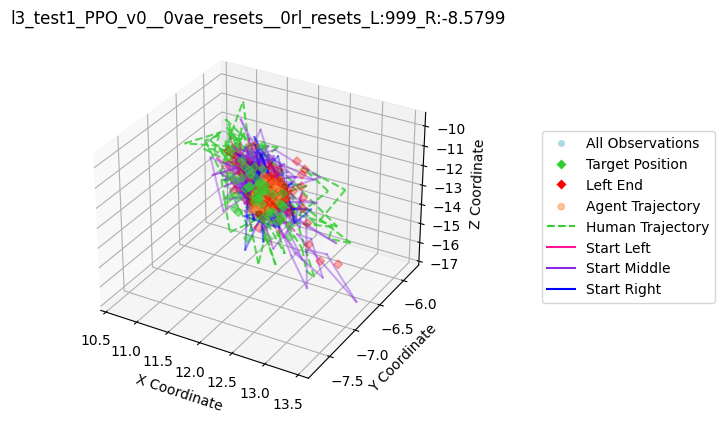

<Monitor<FrameStack<VAE_ENC<PixelObservationWrapper<TimeLimit<OrderEnforcing<PassiveEnvChecker<Continuous_MountainCarEnv<MountainCarContinuous-v0>>>>>>>>>


In [ ]:

agent_versions = ['BCE_VAE_l3_test1_PPO','BCE_VAE_l3_test2_PPO']
for agent_version in agent_versions:
    rl_class = 'PPO'
    vae_dir = 'logs/MountainCar/'+agent_version+'/MSSIMVAE'
    enc_dir = 'RLmodels/MountainCarContinuous-v0/Double_loop/latent_space_encodings/'+agent_version
    agent_dir = 'RLmodels/MountainCarContinuous-v0/Double_loop/end_of_loop_save/'+rl_class+'/'+agent_version
    save_path = 'Plots/'+rl_class+'/'+agent_version



    os.makedirs(save_path, exist_ok=True)
    vae_paths = os.listdir(vae_dir)
    enc_paths =  os.listdir(enc_dir)
    agent_paths =  os.listdir(agent_dir)

    print(vae_paths)
    print(agent_paths)
    print(enc_paths)
    for i in range(len(agent_paths)):



        vae_path = vae_paths[i]

        version_number = vae_path[-1]
        #get vae
        vae = get_vae(version='version_'+version_number, log_directory = vae_dir)
        #encode important positions
        enc_left_pos = encode_tensor(vae,left_pos)
        enc_target_pos = encode_tensor(vae,target_pos)
        enc_start_pos_left = encode_tensor(vae,start_pos_left)
        enc_start_pos_middle = encode_tensor(vae,start_pos_middle)
        enc_start_pos_right = encode_tensor(vae,start_pos_right)
        enc_good_trajectory = encode_tensor(vae, good_trajectory)

        #get agent
        agent = PPO.load(agent_dir+'/'+agent_paths[i])

        #make env
        env = gym.make("MountainCarContinuous-v0",
                    render_mode ='rgb_array')
        seed = 42
        env.reset(seed=seed)
        env = PixelObservationWrapper(env)
        env = VAE_ENC(env, vae, 2)
        env = FrameStack(env, num_stack=2)
        env = Monitor(env)
        agent.env = env
        print(agent.env)
        # make trajectory
        all_latent_trajectories, all_rewards = make_trajectories(agent , env, 3)
        best_trajectory =[]
        best_reward = 0
        if all_rewards[0] > all_rewards[1] and all_rewards[0] > all_rewards[2]:
            best_trajectory.append(all_latent_trajectories[0])
            best_reward = all_rewards[0]
        elif all_rewards[1] > all_rewards[0] and all_rewards[1] > all_rewards[2]:
            best_trajectory.append(all_latent_trajectories[1])
            best_reward = all_rewards[1]
        else:
            best_trajectory.append(all_latent_trajectories[2])
            best_reward = all_rewards[2]
        # get enc
        print(all_rewards)
        known_universe = np.genfromtxt(enc_dir+'/'+enc_paths[i], dtype=float, delimiter=',')
        print(vae_path)
        print(agent_paths[i])
        print(enc_paths[i])
        # plot both
        plot_titel= agent_paths[i][8:-5]+'L:'+str(len(best_trajectory[0]))+'_R:'+str(best_reward)[:-11]
        save_name = save_path+'/'+agent_paths[i][:-6]
        plot_3D_trajectories_with_colors(best_trajectory, enc_good_trajectory, known_universe, enc_left_pos, enc_target_pos,
                                         enc_start_pos_left, enc_start_pos_middle, enc_start_pos_right, save_name, plot_titel)

In [ ]:
agent_versions = ['BCE_VAE_l2_test1_PPO','BCE_VAE_l2_test2_PPO','BCE_VAE_l2_test3_PPO','BCE_VAE_l2_test4_PPO']
for agent_version in agent_versions:
    rl_class = 'PPO'
    vae_dir = 'logs/MountainCar/'+agent_version+'/MSSIMVAE'
    enc_dir = 'RLmodels/MountainCarContinuous-v0/Double_loop/latent_space_encodings/'+agent_version
    agent_dir = 'RLmodels/MountainCarContinuous-v0/Double_loop/end_of_loop_save/'+rl_class+'/'+agent_version
    save_path = 'Plots/'+rl_class+'/'+agent_version



    os.makedirs(save_path, exist_ok=True)
    vae_paths = os.listdir(vae_dir)
    enc_paths =  os.listdir(enc_dir)
    agent_paths =  os.listdir(agent_dir)

    print(vae_paths)
    print(agent_paths)
    print(enc_paths)
    for i in range(len(agent_paths)):



        vae_path = vae_paths[i]

        version_number = vae_path[-1]
        #get vae
        vae = get_vae(version='version_'+version_number, log_directory = vae_dir)
        #encode important positions
        enc_left_pos = encode_tensor(vae,left_pos)
        enc_target_pos = encode_tensor(vae,target_pos)
        enc_start_pos_left = encode_tensor(vae,start_pos_left)
        enc_start_pos_middle = encode_tensor(vae,start_pos_middle)
        enc_start_pos_right = encode_tensor(vae,start_pos_right)
        enc_good_trajectory = encode_tensor(vae, good_trajectory)

        #get agent
        agent = PPO.load(agent_dir+'/'+agent_paths[i])

        #make env
        env = gym.make("MountainCarContinuous-v0",
                    render_mode ='rgb_array')
        seed = 42
        env.reset(seed=seed)
        env = PixelObservationWrapper(env)
        env = VAE_ENC(env, vae, 2)
        env = FrameStack(env, num_stack=2)
        env = Monitor(env)
        agent.env = env
        print(agent.env)
        # make trajectory
        all_latent_trajectories, all_rewards = make_trajectories(agent , env, 3)
        best_trajectory =[]
        best_reward = 0
        if all_rewards[0] > all_rewards[1] and all_rewards[0] > all_rewards[2]:
            best_trajectory.append(all_latent_trajectories[0])
            best_reward = all_rewards[0]
        elif all_rewards[1] > all_rewards[0] and all_rewards[1] > all_rewards[2]:
            best_trajectory.append(all_latent_trajectories[1])
            best_reward = all_rewards[1]
        else:
            best_trajectory.append(all_latent_trajectories[2])
            best_reward = all_rewards[2]
        # get enc
        print(all_rewards)
        known_universe = np.genfromtxt(enc_dir+'/'+enc_paths[i], dtype=float, delimiter=',')
        print(vae_path)
        print(agent_paths[i])
        print(enc_paths[i])
        # plot both
        plot_titel= agent_paths[i][8:-5]+'L:'+str(len(best_trajectory[0]))+'_R:'+str(best_reward)[:-11]
        save_name = save_path+'/'+agent_paths[i][:-6]
        plot_2D_trajectories_with_colors(best_trajectory, enc_good_trajectory, known_universe, enc_left_pos, enc_target_pos,
                                         enc_start_pos_left, enc_start_pos_middle, enc_start_pos_right, save_name, plot_titel)

In [ ]:
agent_versions = ['BCE_VAE_l1_test2_PPO', 'BCE_VAE_l1_test3_PPO','BCE_VAE_l1_test4_PPO','BCE_VAE_l1_test5_PPO']
for agent_version in agent_versions:
    rl_class = 'PPO'
    vae_dir = 'logs/MountainCar/'+agent_version+'/MSSIMVAE'
    enc_dir = 'RLmodels/MountainCarContinuous-v0/Double_loop/latent_space_encodings/'+agent_version
    agent_dir = 'RLmodels/MountainCarContinuous-v0/Double_loop/end_of_loop_save/'+rl_class+'/'+agent_version
    save_path = 'Plots/'+rl_class+'/'+agent_version



    os.makedirs(save_path, exist_ok=True)
    vae_paths = os.listdir(vae_dir)
    enc_paths =  os.listdir(enc_dir)
    agent_paths =  os.listdir(agent_dir)

    print(vae_paths)
    print(agent_paths)
    print(enc_paths)
    for i in range(len(agent_paths)):



        vae_path = vae_paths[i]

        version_number = vae_path[-1]
        #get vae
        vae = get_vae(version='version_'+version_number, log_directory = vae_dir)
        #encode important positions
        enc_left_pos = encode_tensor(vae,left_pos)
        enc_target_pos = encode_tensor(vae,target_pos)
        enc_start_pos_left = encode_tensor(vae,start_pos_left)
        enc_start_pos_middle = encode_tensor(vae,start_pos_middle)
        enc_start_pos_right = encode_tensor(vae,start_pos_right)
        enc_good_trajectory = encode_tensor(vae, good_trajectory)

        #get agent
        agent = PPO.load(agent_dir+'/'+agent_paths[i])

        #make env
        env = gym.make("MountainCarContinuous-v0",
                    render_mode ='rgb_array')
        seed = 42
        env.reset(seed=seed)
        env = PixelObservationWrapper(env)
        env = VAE_ENC(env, vae, 2)
        env = FrameStack(env, num_stack=2)
        env = Monitor(env)
        agent.env = env
        print(agent.env)
        # make trajectory
        all_latent_trajectories, all_rewards = make_trajectories(agent , env, 3)
        best_trajectory =[]
        best_reward = 0
        if all_rewards[0] > all_rewards[1] and all_rewards[0] > all_rewards[2]:
            best_trajectory.append(all_latent_trajectories[0])
            best_reward = all_rewards[0]
        elif all_rewards[1] > all_rewards[0] and all_rewards[1] > all_rewards[2]:
            best_trajectory.append(all_latent_trajectories[1])
            best_reward = all_rewards[1]
        else:
            best_trajectory.append(all_latent_trajectories[2])
            best_reward = all_rewards[2]
        # get enc
        print(all_rewards)
        known_universe = np.genfromtxt(enc_dir+'/'+enc_paths[i], dtype=float, delimiter=',')
        print(vae_path)
        print(agent_paths[i])
        print(enc_paths[i])
        # plot both
        plot_titel= agent_paths[i][8:-5]+'L:'+str(len(best_trajectory[0]))+'_R:'+str(best_reward)[:-11]
        save_name = save_path+'/'+agent_paths[i][:-6]
        plot_1D_trajectories_with_colors(best_trajectory, enc_good_trajectory, known_universe, enc_left_pos, enc_target_pos,
                                         enc_start_pos_left, enc_start_pos_middle, enc_start_pos_right, save_name, plot_titel)


In [95]:
agent_versions = 'BCE_VAE_l1_test2_PPO'
vae_dir = 'logs/MountainCar/'+agent_version+'/MSSIMVAE'
vae = get_vae(version='version_0', log_directory = vae_dir)
#encode important positions
enc_left_pos = encode_tensor(vae,left_pos)
enc_target_pos = encode_tensor(vae,target_pos)
enc_start_pos_left = encode_tensor(vae,start_pos_left)
enc_start_pos_middle = encode_tensor(vae,start_pos_middle)
enc_start_pos_right = encode_tensor(vae,start_pos_right)
enc_good_trajectory = encode_tensor(vae, good_trajectory)

In [101]:
enc_good_trajectory[-1]

array([ 11.519036 ,  -6.7507005, -11.152732 ], dtype=float32)

In [90]:
good_trajectory.shape()

TypeError: 'torch.Size' object is not callable

In [85]:
Image.fromarray(np.array(good_trajectory[-1].transpose(1, 2, 0)))

TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [99]:
enc_target_pos

array([[ 11.653109 ,  -6.8229246, -11.053818 ],
       [ 11.900632 ,  -7.240586 , -11.742794 ],
       [ 11.753326 ,  -6.309108 , -11.704661 ],
       [ 11.672081 ,  -6.640164 , -11.740602 ],
       [ 12.488181 ,  -6.8560653, -12.955569 ],
       [ 12.575117 ,  -6.960999 , -12.698831 ],
       [ 12.259529 ,  -7.022952 , -12.935054 ],
       [ 12.722173 ,  -7.4249325, -12.305603 ],
       [ 12.141144 ,  -6.6732283, -12.054218 ],
       [ 12.029487 ,  -7.2443   , -12.119991 ],
       [ 12.141335 ,  -6.8376055, -12.385773 ],
       [ 12.244622 ,  -7.1795034, -11.932105 ],
       [ 11.837442 ,  -6.7187953, -11.422538 ],
       [ 12.107555 ,  -7.1535797, -12.163444 ],
       [ 12.02814  ,  -6.713458 , -11.97672  ],
       [ 12.805228 ,  -7.537619 , -13.263487 ],
       [ 12.159397 ,  -7.2189274, -12.290235 ],
       [ 11.76787  ,  -6.3992944, -11.668531 ],
       [ 11.888176 ,  -7.2821283, -11.683429 ],
       [ 11.854701 ,  -6.5960836, -12.15961  ],
       [ 11.473944 ,  -6.8010416, -11.78

In [161]:
def plot_3D_trajectories_with_colors(trajectories, universe_points, 
                                     left_pos, target_pos, 
                                     start_pos_left, start_pos_middle, start_pos_right,
                                     save_name, plot_title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    colormaps = ['Oranges', 'Blues', 'Greens', 'Purples', 'Reds',
                 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

    legend_labels = ['Universe Points', 'Start Left', 'Start Middle', 'Start Right', 'Left End', 'Target Position']
    legend_handles = []

    i = 0
    for trajectory in trajectories:
        x = trajectory[:, 0]
        y = trajectory[:, 1]
        z = trajectory[:, 2]

        ax.scatter(universe_points[:, 0], universe_points[:, 1], universe_points[:, 2], c='lightblue', alpha=0.005)
        ax.scatter(start_pos_left[:, 0], start_pos_left[:, 1], start_pos_left[:, 2], c='deeppink', alpha=0.1)
        ax.scatter(start_pos_middle[:, 0], start_pos_middle[:, 1], start_pos_middle[:, 2], c='blueviolet', alpha=0.1)
        ax.scatter(start_pos_right[:, 0], start_pos_right[:, 1], start_pos_right[:, 2], c='forestgreen', alpha=0.1)
        ax.scatter(left_pos[:, 0], left_pos[:, 1], left_pos[:, 2], c='red', alpha=0.3)
        ax.scatter(target_pos[:, 0], target_pos[:, 1], target_pos[:, 2], c='limegreen', alpha=0.3)

        num_frames = len(trajectory)
        color_values = np.linspace(0.5, 1, num_frames)

        colormap_index = i % len(colormaps)
        cmap = cm.get_cmap(colormaps[colormap_index])

        normalized_color_values = (color_values - np.min(color_values)) / (np.max(color_values) - np.min(color_values))
        trajectory_colors = cmap(normalized_color_values)
        
        start_index = int(num_frames * (1 / 2))
        trajectory_colors[:start_index] = trajectory_colors[start_index]
        
        scatter = ax.scatter(x, y, z, c=trajectory_colors, alpha=0.8, marker='o', label=f'Trajectory {i+1}')

        legend_handles.append(scatter)

        i += 1

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title(plot_title)

    ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))  # Position the legend to the right of the plot

    plt.savefig(save_name + '_3D.pdf', bbox_inches='tight')
    plt.show()






In [223]:

def plot_3D_trajectories_with_colors(trajectories, universe_points, 
                                     left_pos, target_pos, 
                                     start_pos_left, start_pos_middle, start_pos_right,
                                     save_name, plot_title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    colormaps = ['Oranges', 'Blues', 'Greens', 'Purples', 'Reds',
                 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

    legend_labels = ['All Observations', 'Start Left', 'Start Middle', 'Start Right', 'Left End', 'Target Position']
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                      for color, label in zip(['lightblue', 'deeppink', 'blueviolet', 'forestgreen', 'red', 'limegreen'], legend_labels)]


    i = 0
    for trajectory in trajectories:
        x = trajectory[:, 0]
        y = trajectory[:, 1]
        z = trajectory[:, 2]

        num_frames = len(trajectory)
        color_values = np.linspace(0.5, 1, num_frames)

        colormap_index = i % len(colormaps)
        cmap = cm.get_cmap(colormaps[colormap_index])

        normalized_color_values = (color_values - np.min(color_values)) / (np.max(color_values) - np.min(color_values))
        trajectory_colors = cmap(normalized_color_values)
        
        start_index = int(num_frames * (1 / 2))
        trajectory_colors[:start_index] = trajectory_colors[start_index]
        
        scatter = ax.scatter(x, y, z, c=trajectory_colors, alpha=0.5, marker='o', label=f'Trajectory {i+1}')
        
        legend_handles.append(scatter)
        legend_labels.append(f'Trajectory {i+1}')
#         for j in range(num_frames - 1):
#             ax.plot([x[j], x[j+1]], [y[j], y[j+1]], [z[j], z[j+1]], c=trajectory_colors[j], linewidth=2, alpha=0.8)

#         legend_handles.append(ax.plot([], [], c=trajectory_colors[0], label=f'Trajectory {i+1}')[0])
#         legend_labels.append(f'Trajectory {i+1}')
        
#         i += 1

    ax.scatter(universe_points[:, 0], universe_points[:, 1], universe_points[:, 2], c='lightblue', alpha=0.002, label='Universe Points')
#     ax.scatter(start_pos_left[:, 0], start_pos_left[:, 1], start_pos_left[:, 2],marker='^', c='firebrick', alpha=0.01, label='Start Left')
#     ax.scatter(start_pos_middle[:, 0], start_pos_middle[:, 1], start_pos_middle[:, 2],marker='^', c='blueviolet', alpha=0.01, label='Start Middle')
#     ax.scatter(start_pos_right[:, 0], start_pos_right[:, 1], start_pos_right[:, 2],marker='^', c='forestgreen', alpha=0.01, label='Start Right')
    # Plot lines connecting start points
    def plot_start_lines(start_points, color):
        num_start_points = start_points.shape[0]
        for i in range(num_start_points - 1):
            ax.plot(start_points[i:i+2, 0], start_points[i:i+2, 1], start_points[i:i+2, 2], c=color, alpha=0.5)

    plot_start_lines(start_pos_left, 'deeppink')
    plot_start_lines(start_pos_middle, 'blueviolet')
    plot_start_lines(start_pos_right, 'forestgreen')
    
    #ax.scatter(left_pos[:, 0], left_pos[:, 1], left_pos[:, 2], c='red', marker='x',alpha=0.3, label='Left End')
    ax.scatter(left_pos[:, 0], left_pos[:, 1], left_pos[:, 2], c='red', marker='D',alpha=0.3, label='Left End')
    #ax.scatter(target_pos[:, 0], target_pos[:, 1], target_pos[:, 2],marker='x', c='limegreen', alpha=0.3, label='Target Position')
    ax.scatter(target_pos[:, 0], target_pos[:, 1], target_pos[:, 2],marker='D', c='limegreen', alpha=0.5, label='Target Position')

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title(plot_title)

    ax.legend(handles=legend_handles, labels=legend_labels, loc='center left', bbox_to_anchor=(1.25, 0.5))  # Position the legend to the right of the plot

    plt.savefig(save_name + '_3D.pdf', bbox_inches='tight')
    plt.show()


In [14]:
plot_3D_trajectories_with_colors(all_latent_trajectories, known_universe, enc_left_pos, enc_target_pos,
                                     enc_start_pos_left, enc_start_pos_middle, enc_start_pos_right, save_name, plot_titel)

TypeError: plot_3D_trajectories_with_colors() missing 1 required positional argument: 'plot_title'

'Plots/PPO/BCE_VAE_l2_test2_PPO/BCE_VAE_l2_test2_PPO_v9__1vae_resets__3rl_resets'

In [70]:
v_transforms = transforms.ToTensor()
rec_target  = vae.decode(v_transforms(enc_target_pos))

In [93]:
v_transforms = transforms.ToTensor()
rec_target  = vae.decode(v_transforms(enc_target_pos))
rec_left=vae.decode(v_transforms(enc_left_pos))
rec_middle=vae.decode(v_transforms(enc_start_pos_middle))

dec_target = np.array([tensor.detach().cpu().numpy() for tensor in rec_target])
dec_left = np.array([tensor.detach().cpu().numpy() for tensor in rec_left])
dec_middle = np.array([tensor.detach().cpu().numpy() for tensor in rec_middle])

In [89]:
dec = np.array([tensor.detach().cpu().numpy() for tensor in rec])
dec2 = np.array([tensor.detach().cpu().numpy() for tensor in rec_left])
dec3 = np.array([tensor.detach().cpu().numpy() for tensor in rec_middle])

In [92]:
start_pos_middle.shape


torch.Size([200, 3, 64, 64])

In [96]:
dec2.shape

(50, 3, 64, 64)

In [98]:
scaled_dec_target.shape

AttributeError: 'list' object has no attribute 'shape'

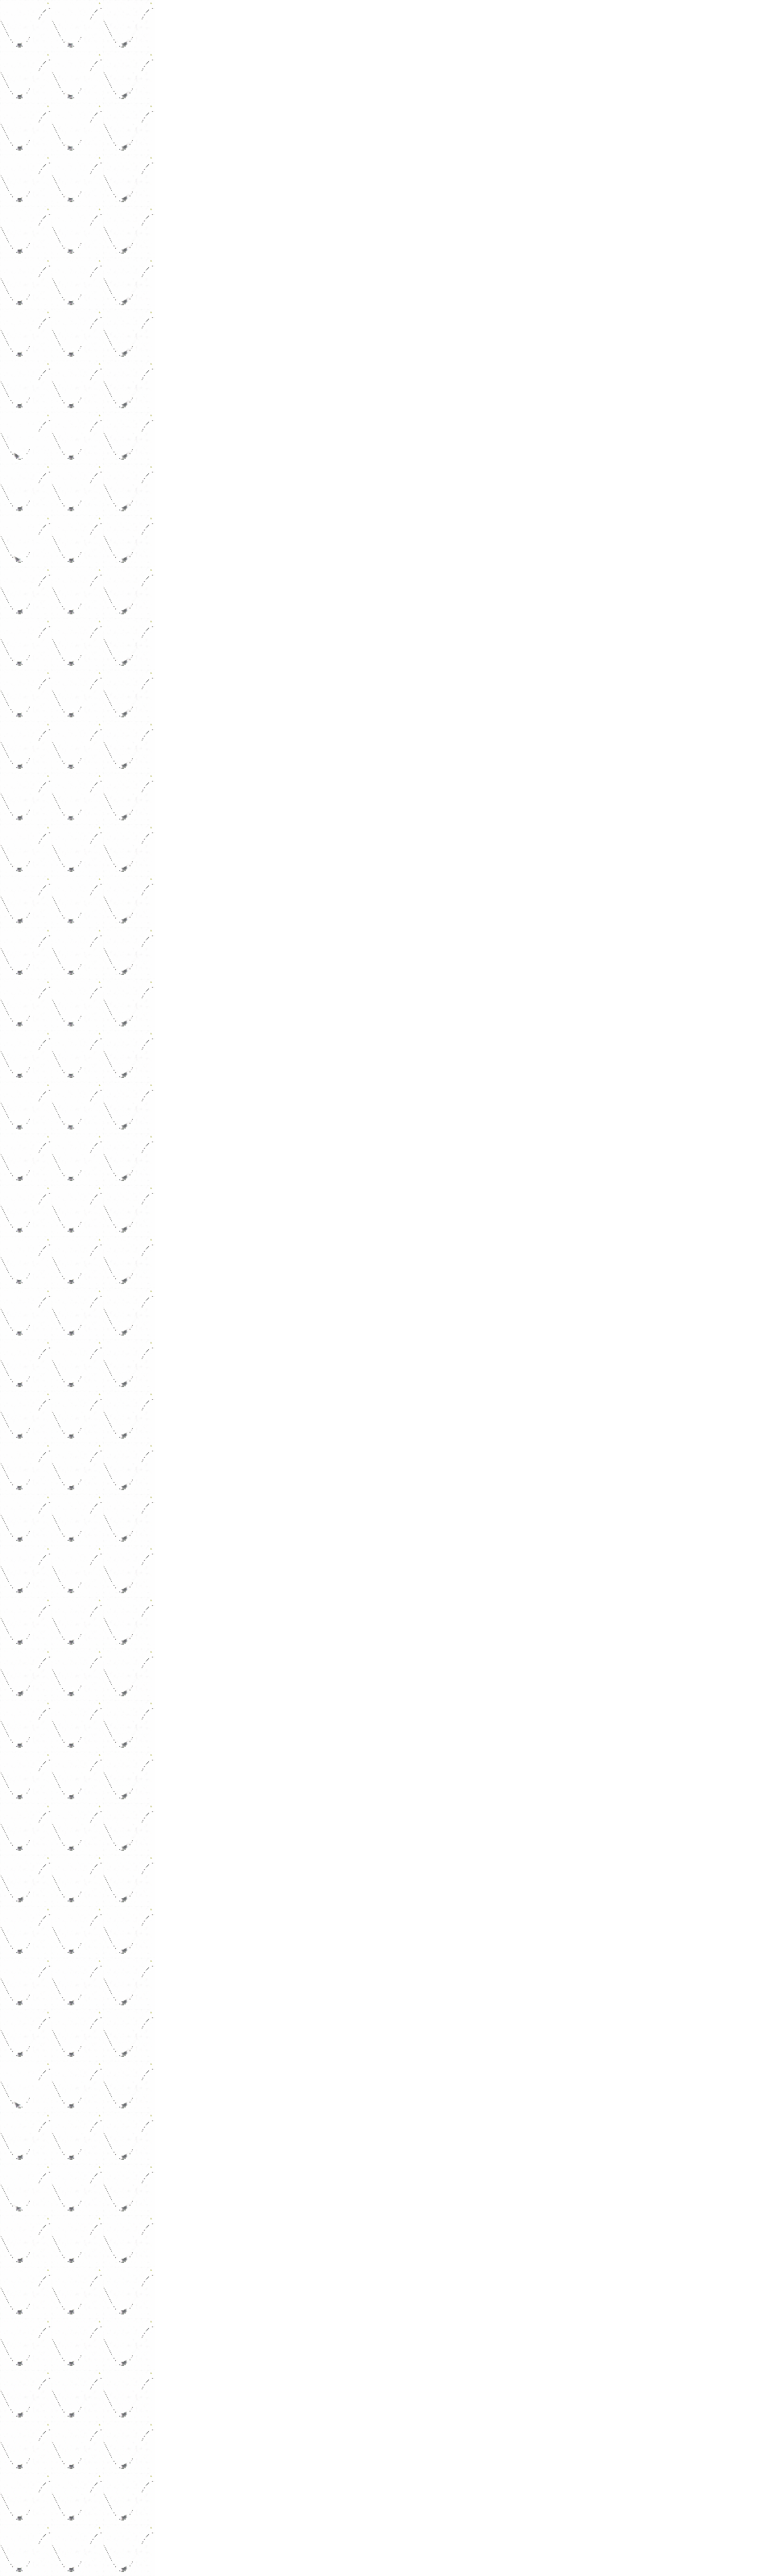

In [110]:
# Scale normalized values back to [0, 255] range and convert to uint8
scaled_dec_target = np.array([(img_array * 255).astype(np.uint8) for img_array in dec_target])
scaled_dec_left = np.array([(img_array * 255).astype(np.uint8) for img_array in dec_left])
scaled_dec_middle = np.array([(img_array * 255).astype(np.uint8) for img_array in dec_middle[:50]])  # Take the first 50 images

# Combine the scaled arrays
combined_arrays = list(zip(scaled_dec_target, scaled_dec_left, scaled_dec_middle))

# Calculate the canvas size
num_rows = len(combined_arrays)
num_cols = 15  # Three images in each row
image_width, image_height = 64, 64
canvas_width = num_cols * image_width
canvas_height = num_rows * image_height

# Create an empty canvas with white background
canvas = Image.new('RGB', (canvas_width, canvas_height), 'white')

# Paste each set of images onto the canvas at specified positions
for row, images in enumerate(combined_arrays):
    for col, img_array in enumerate(images):

        img = Image.fromarray(img_array.transpose(1, 2, 0))
        canvas.paste(img, (col * image_width, row * image_height))

# Display the canvas with all images
canvas.show()

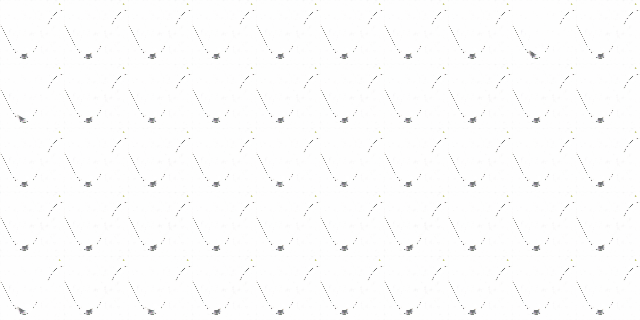

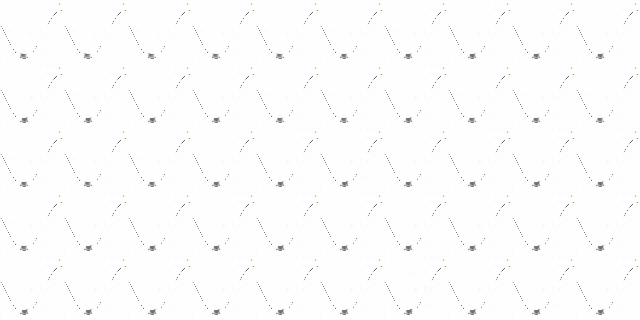

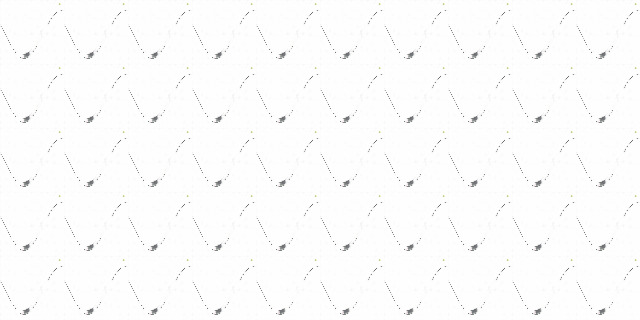

In [113]:
def display_images_as_grid(image_arrays, num_rows, num_cols):
    # Scale normalized values back to [0, 255] range and convert to uint8
    scaled_img_arrays = [(img_array * 255).astype(np.uint8) for img_array in image_arrays]

    # Calculate the canvas size
    image_width, image_height = scaled_img_arrays[0].shape[1], scaled_img_arrays[0].shape[2]
    canvas_width = num_cols * image_width
    canvas_height = num_rows * image_height

    # Create an empty canvas with white background
    canvas = Image.new('RGB', (canvas_width, canvas_height), 'white')

    # Paste each image onto the canvas at specified positions
    for row in range(num_rows):
        for col in range(num_cols):
            index = row * num_cols + col
            if index < len(scaled_img_arrays):
                img = Image.fromarray(scaled_img_arrays[index].transpose(1, 2, 0))  # Transpose to match PIL's channel order (HWC)
                canvas.paste(img, (col * image_width, row * image_height))

    # Display the canvas with all images
    canvas.show()

# Call the function for each array
display_images_as_grid(dec_target, num_rows=5, num_cols=10)
display_images_as_grid(dec_left, num_rows=5, num_cols=10)
display_images_as_grid(dec_middle[:50], num_rows=5, num_cols=10)

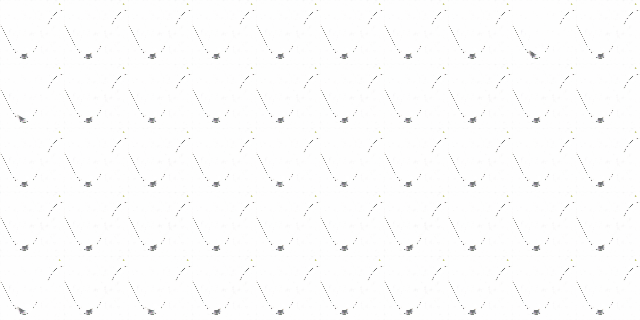

In [101]:
# Assuming img_arrays is a list of 50 normalized image arrays (3x64x64)
img_arrays = dec2  # Your list of normalized image arrays here

# Scale normalized values back to [0, 255] range and convert to uint8
scaled_img_arrays = [(img_array * 255).astype(np.uint8) for img_array in img_arrays]

# Calculate the canvas size
num_rows = 5  # Number of rows
num_cols = 10  # Number of columns
image_width, image_height = scaled_img_arrays[0].shape[1], scaled_img_arrays[0].shape[2]
canvas_width = num_cols * image_width
canvas_height = num_rows * image_height

# Create an empty canvas with white background
canvas = Image.new('RGB', (canvas_width, canvas_height), 'white')

# Paste each image onto the canvas at specified positions
for row in range(num_rows):
    for col in range(num_cols):
        index = row * num_cols + col
        if index < len(scaled_img_arrays):
            img = Image.fromarray(scaled_img_arrays[index].transpose(1, 2, 0))  # Transpose to match PIL's channel order (HWC)
            canvas.paste(img, (col * image_width, row * image_height))

# Display the canvas with all images
canvas.show()